# Predicting Breast Cancer
#####  Develop a predictive model to classify breast tumors as benign or malignant based on laboratory measurements. Explore and analyze the dataset to identify important features and correlations. Build and compare Decision Tree, K-Nearest Neighbors, and Random Forest models using cross-validation and hyperparameter tuning. Evaluate the best model's performance on a holdout test set and report classification metrics such as accuracy, precision, recall, and F1 score. 
##### The project aims to contribute to more accurate and effective breast cancer diagnosis, leading to better treatment outcomes.

AI In Enterprise - Lab2

Shahabuddin Syed, 100895169

In [1]:
# importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
# lead the csv into pandas dataframe
cancer_data = pd.read_csv('dataset.csv')
cancer_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,87139402,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,...,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,8910251,B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,...,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,905520,B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,...,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,868871,B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,...,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,9012568,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,...,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


- There are 30 numeric laboratory measurements features
- Column diagnosis is the target variable showing if the cancer is malignant or benign


In [3]:
# drop the ID and look at the columns info
cancer_data = cancer_data.drop('id', axis=1)
cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis          569 non-null    object 
 1   radius_mean        569 non-null    float64
 2   texture_mean       569 non-null    float64
 3   perimeter_mean     569 non-null    float64
 4   area_mean          569 non-null    float64
 5   smoothness_mean    569 non-null    float64
 6   compactness_mean   569 non-null    float64
 7   concavity_mean     569 non-null    float64
 8   points_mean        569 non-null    float64
 9   symmetry_mean      569 non-null    float64
 10  dimension_mean     569 non-null    float64
 11  radius_se          569 non-null    float64
 12  texture_se         569 non-null    float64
 13  perimeter_se       569 non-null    float64
 14  area_se            569 non-null    float64
 15  smoothness_se      569 non-null    float64
 16  compactness_se     569 non

- No Null values
- All numeric columns are of float64 type
- We can remove id


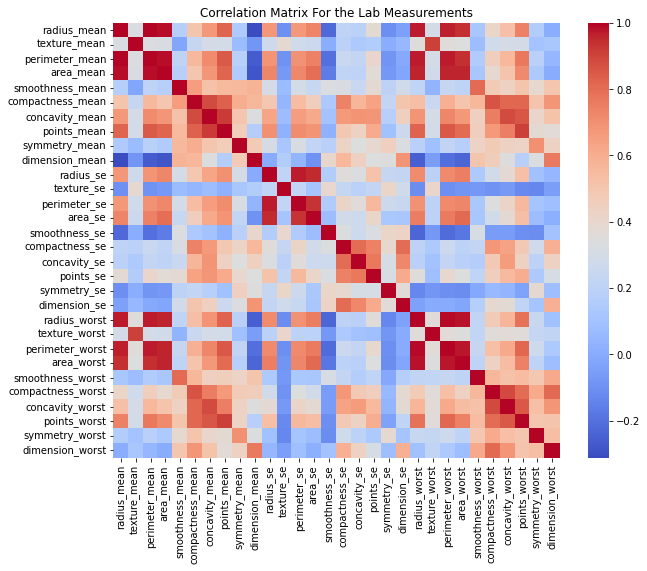

In [4]:
# understanding Correlation
corr_matrix = cancer_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix For the Lab Measurements')
plt.show()

- There are few highly correlated variables, lets remove them

In [5]:
# Calculate the correlation matrix
corr_matrix = cancer_data.corr().abs()

# Create a boolean mask of the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Set a threshold value for correlation coefficient, say 0.9
threshold = 0.9

# Find the index of columns that have a correlation coefficient greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop the highly correlated variables
cancer_data.drop(to_drop, axis=1, inplace=True)


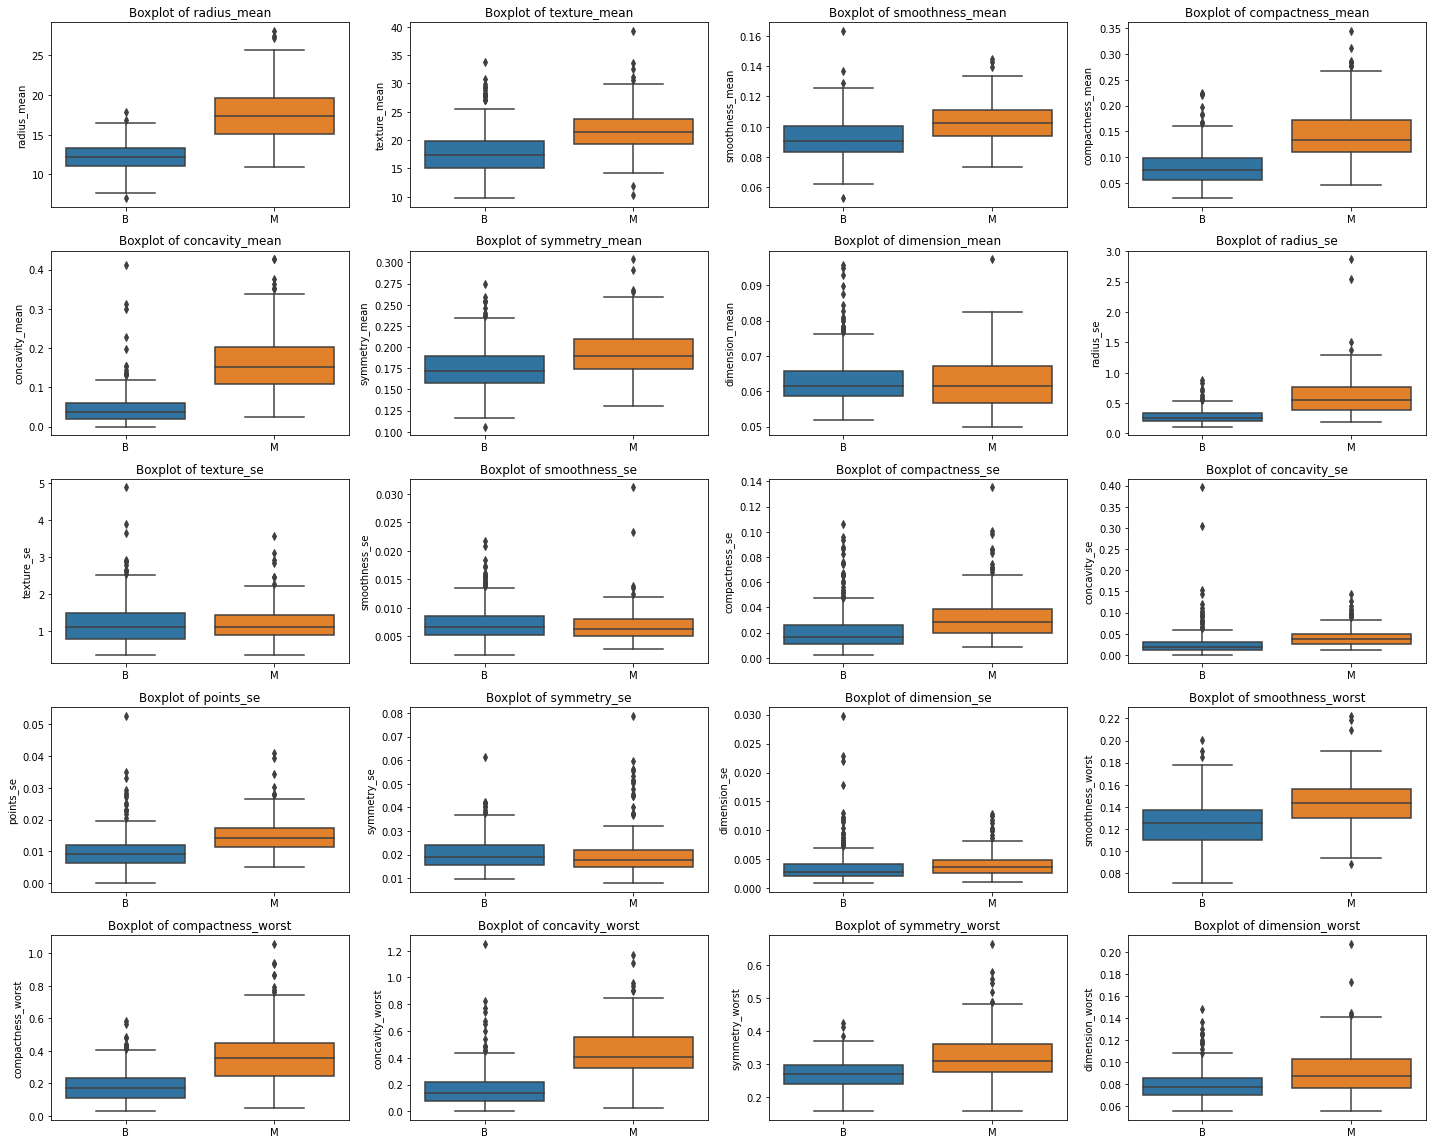

In [6]:
lab_meas = cancer_data.columns[1:]

# Create a 5x6 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 16))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Create box plots for each feature
for i, col in enumerate(lab_meas):
    sns.boxplot(x='diagnosis', y=col, data=cancer_data, ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel(col)
    axs[i].set_title('Boxplot of ' + col)

plt.tight_layout()
plt.show()

- Its clear that for malignant the lab measuremet values are higher
- There seems to be some outliers we might have to treat these or use a model which natively handles outliers like RandomForest (since we have less data points it would be bad to drop rows)

In [7]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def build_model(X_train, y_train, model, params, cv=5):
    """
    A function to build a classification model using GridSearchCV and cross-validation.

    Parameters:
    X_train: numpy array or pandas DataFrame, training dataset with numerical features
    y_train: numpy array or pandas Series, training dataset target variable
    model: sklearn estimator object, classification model to be built
    params: dictionary, hyperparameters to be tuned using GridSearchCV
    cv: int, number of cross-validation folds (default: 5)

    Returns:
    clf: sklearn estimator object, best classification model
    """
    # Create GridSearchCV object
    clf = GridSearchCV(model, params, cv=cv)

    # Fit GridSearchCV object on training data
    clf.fit(X_train, y_train)

    # Print best hyperparameters
    print("Best Hyperparameters: ", clf.best_params_)

    # Return best classification model
    return clf


def evaluate_model(model, X_test, y_test):
    """
    A function to evaluate the performance of a classification model.

    Parameters:
    model: sklearn estimator object, classification model to be evaluated
    X_test: numpy array or pandas DataFrame, test dataset with numerical features
    y_test: numpy array or pandas Series, test dataset target variable

    Returns:
    accuracy: float, accuracy score of the model
    precision: float, precision score of the model
    recall: float, recall score of the model
    f1: float, f1 score of the model
    """
    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print evaluation metrics
    print("Accuracy: ", round(accuracy,3))
    print("Precision: ", round(precision,3))
    print("Recall: ", round(recall,3))
    print("F1 Score: ", round(f1,3))

    # Return evaluation metrics
    return accuracy, precision, recall, f1

In [8]:

x = cancer_data.drop('diagnosis', axis=1)
y = cancer_data['diagnosis'].map({'M':1, 'B':0})

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)


In [9]:
# Trying Dt without hyperparameter tuning
print('Decision Tree with Default parameters, Performance :')
dt_model = build_model(X_train, y_train, DecisionTreeClassifier(random_state=42), {})
dt_acc, dt_prec, dt_rec, dt_f1 = evaluate_model(dt_model, X_test, y_test)

Decision Tree with Default parameters, Performance :
Best Hyperparameters:  {}
Accuracy:  0.923
Precision:  0.885
Recall:  0.902
F1 Score:  0.893


In [10]:

# Define the hyperparameters to tune using GridSearchCV for each model
dt_params = {'max_depth': [2, 4, 6, 8, 10]}
knn_params = {'n_neighbors': [3, 5, 7, 9]}
rf_params = {'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 4, 6, 8, 10]}

print('Decision Performance with Hyperparameter Tuning :')
# Build the Decision Tree model using GridSearchCV and cross-validation
dt_model = build_model(X_train, y_train, DecisionTreeClassifier(random_state=42), dt_params)
dt_acc, dt_prec, dt_rec, dt_f1 = evaluate_model(dt_model, X_test, y_test)
print()
print('KNN Performance with Hyperparameter Tuning :')
# Build the KNN model using GridSearchCV and cross-validation
knn_model = build_model(X_train, y_train, KNeighborsClassifier(), knn_params)
knn_acc, knn_prec, knn_rec, knn_f1 = evaluate_model(knn_model, X_test, y_test)

print()
print('Random Forest Performance with Hyperparameter Tuning :')
# Build the Random Forest model using GridSearchCV and cross-validation
rf_model = build_model(X_train, y_train, RandomForestClassifier(random_state=42), rf_params)
rf_acc, rf_prec, rf_rec, rf_f1 = evaluate_model(rf_model, X_test, y_test)

Decision Performance with Hyperparameter Tuning :
Best Hyperparameters:  {'max_depth': 8}
Accuracy:  0.923
Precision:  0.885
Recall:  0.902
F1 Score:  0.893

KNN Performance with Hyperparameter Tuning :
Best Hyperparameters:  {'n_neighbors': 9}
Accuracy:  0.944
Precision:  0.957
Recall:  0.882
F1 Score:  0.918

Random Forest Performance with Hyperparameter Tuning :
Best Hyperparameters:  {'max_depth': 8, 'n_estimators': 150}
Accuracy:  0.965
Precision:  0.926
Recall:  0.98
F1 Score:  0.952


**If I have to choose the best model from these I would choose Random Forest.<br>**
The metric which is more important to us for this particular problem is **recall**. False Negative will cost us more, Recall penalizes False Negatives.

**There you have it, we have looked at data, did some analysis, removed correlated columns, understood distribution and build models with and without hyperparameter tuning, Best Model was Random Forest with Tuning :)**